In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

import zipfile
import pandas as pd
import os
from tqdm import tqdm


In [47]:
import os
import pandas as pd

path = 'ChengDuData'
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]

combined_dataframe = pd.DataFrame()

for file in csv_files:
    file_path = os.path.join(path, file)
    temp_df = pd.read_csv(file_path)
    
    # Compute the average travel time
    temp_df['Average_Travel_Time'] = temp_df.iloc[:, 8:59].mean(axis=1)
    
    # Extract time period information from file name
    time_period = file.replace('.csv', '').replace('_', ' ')
    temp_df['Time_Period'] = time_period

    # Select relevant columns (optional, depending on your model requirements)
    temp_df = temp_df[['Link', 'Node_Start', 'Longitude_Start', 'Latitude_Start', 
                       'Node_End', 'Longitude_End', 'Latitude_End', 'Length', 
                       'Average_Travel_Time', 'Time_Period']]
    
    combined_dataframe = pd.concat([combined_dataframe, temp_df], ignore_index=True)

# Now combined_dataframe contains the processed data


In [48]:
print(combined_dataframe.head())

   Link  Node_Start  Longitude_Start  Latitude_Start  Node_End  Longitude_End  \
0     0           0       103.946006       30.750660        16     103.952551   
1     1           0       103.946006       30.750660        48     103.956494   
2     2           0       103.946006       30.750660        64     103.941276   
3     3           1       104.062539       30.739077       311     104.060024   
4     4           1       104.062539       30.739077      1288     104.062071   

   Latitude_End       Length  Average_Travel_Time       Time_Period  
0     30.756752   921.041014            85.424151  Weekday Off peak  
1     30.745080  1179.207157           125.386769  Weekday Off peak  
2     30.754493   620.905375            53.618874  Weekday Off peak  
3     30.742693   467.552294            40.787167  Weekday Off peak  
4     30.732501   730.287581            77.209144  Weekday Off peak  


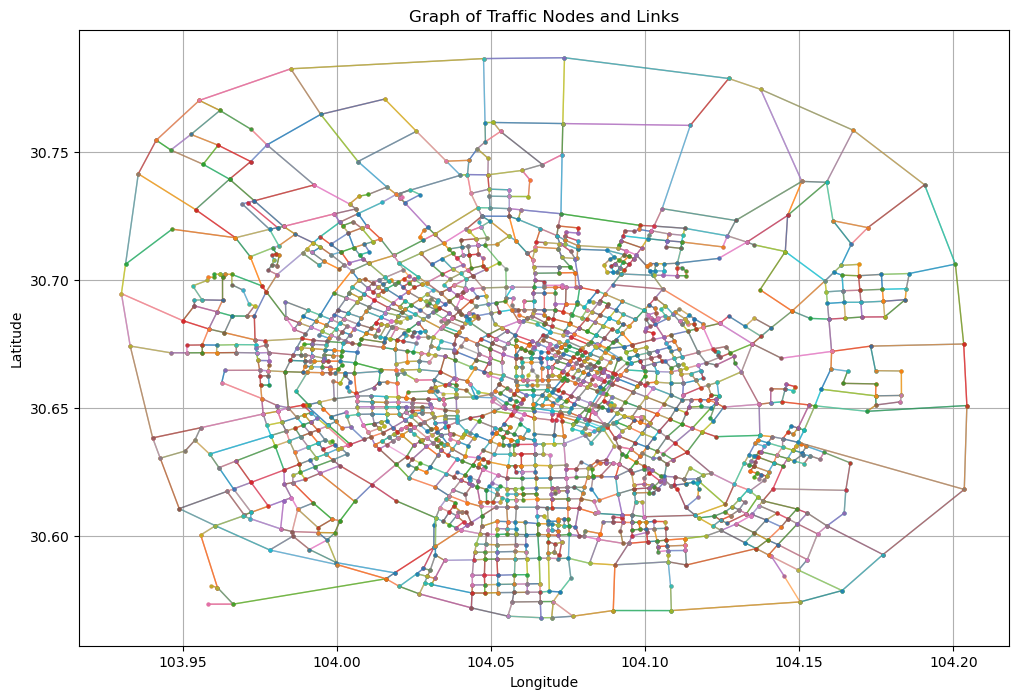

In [88]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('./ChengDuData/Weekday_Peak.csv')
# Function to plot the nodes and links on a map
def plot_graph(df):
    plt.figure(figsize=(12, 8))
    
    # Plot each link in the DataFrame
    for _, row in df.iterrows():
        # Plot start and end nodes
        plt.plot([row['Longitude_Start'], row['Longitude_End']], 
                 [row['Latitude_Start'], row['Latitude_End']], 
                 'o-', markersize=2, linewidth=1, alpha=0.6)
    
    plt.title('Graph of Traffic Nodes and Links')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

# Call the function to plot the graph
plot_graph(df)

In [49]:
def haversine(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))  # No change required here, but ensure 'a' does not exceed 1
    
    # 6371 km is the radius of the Earth
    km = 6371 * c
    return km

Preprocessing

In [50]:
# Calculate distance and add it as a new feature (haversine)
combined_dataframe['Distance'] = combined_dataframe.apply(
    lambda row: haversine(row['Longitude_Start'], row['Latitude_Start'],
                          row['Longitude_End'], row['Latitude_End']), axis=1)

# Features and targets
X = combined_dataframe[['Link', 'Node_Start', 'Longitude_Start', 'Latitude_Start', 
                        'Node_End', 'Longitude_End', 'Latitude_End', 'Distance']].values
y = combined_dataframe['Average_Travel_Time'].values  # Assuming this is your target variable

# Splitting the dataset into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)  # Apply the same transformation to validation data

# Convert to torch tensors
train_features = torch.tensor(X_train_scaled, dtype=torch.float32)
train_labels = torch.tensor(y_train, dtype=torch.float32)
val_features = torch.tensor(X_val_scaled, dtype=torch.float32)
val_labels = torch.tensor(y_val, dtype=torch.float32) 

In [51]:
# Creating TensorDataset objects for training and validation sets
train_dataset = TensorDataset(train_features, train_labels)
val_dataset = TensorDataset(val_features, val_labels)

# Creating DataLoader instances to load data in batches
# You can adjust the batch_size according to your system's capabilities
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

Model Architecture

In [52]:
class EnhancedTravelTimePredictor(nn.Module):
    def __init__(self):
        super(EnhancedTravelTimePredictor, self).__init__()
        self.fc1 = nn.Linear(8, 128)  # Adjust input features if necessary
        self.bn1 = nn.BatchNorm1d(128)  # Corrected to match the output features of fc1
        self.dropout1 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)  # Corrected to match the output features of fc3
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x


In [53]:
#model instantiation
model = EnhancedTravelTimePredictor()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1) #learning rate

In [54]:
#checkpoint saving
model_path = './model_checkpoints'
os.makedirs(model_path, exist_ok=True)
checkpoint_name = os.path.join(model_path, 'checkpoint_{epoch}.pth')

Model Training

In [55]:
#if gpu not enough eiei norng momo

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to the appropriate device


EnhancedTravelTimePredictor(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)

In [56]:
num_epochs = 25000
early_stopping_threshold = 5  # Define the early stopping threshold
best_val_loss = np.inf
patience_counter = 0

# Initialising lists to hold metrics
train_mae, val_mae = [], []
train_rmse, val_rmse = [], []
train_losses, val_losses = [], []
    
for epoch in range(num_epochs):
    # Training phase setup
    model.train()
    epoch_train_losses, train_predictions, train_targets = [], [], []
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()  # Adjust if necessary for your model's output shape
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        epoch_train_losses.append(loss.item())  # Collect loss for each batch
        
        # Collect predictions and targets for metrics calculation
        train_predictions.extend(outputs.detach().cpu().numpy())
        train_targets.extend(targets.cpu().numpy())

    avg_train_loss = np.mean(epoch_train_losses)
    train_losses.append(avg_train_loss)  # Append average training loss for the epoch
    
    # Calculate and update training metrics
    epoch_train_mae = mean_absolute_error(train_targets, train_predictions)
    epoch_train_rmse = np.sqrt(mean_squared_error(train_targets, train_predictions))
    train_mae.append(epoch_train_mae)
    train_rmse.append(epoch_train_rmse)

    # Validation phase setup
    model.eval()
    val_predictions, val_targets, epoch_val_losses = [], [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()  # Adjust if necessary
            loss = criterion(outputs, targets)
            
            epoch_val_losses.append(loss.item())
            
            # Collect predictions and targets for metrics calculation
            val_predictions.extend(outputs.detach().cpu().numpy())
            val_targets.extend(targets.cpu().numpy())

    avg_val_loss = np.mean(epoch_val_losses)
    val_losses.append(avg_val_loss)

    # Calculate and append validation metrics
    epoch_val_mae = mean_absolute_error(val_targets, val_predictions)
    epoch_val_rmse = np.sqrt(mean_squared_error(val_targets, val_predictions))
    val_mae.append(epoch_val_mae)
    val_rmse.append(epoch_val_rmse)

    # Optional: logging for training and validation
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train MAE: {epoch_train_mae:.4f}, Train RMSE: {epoch_train_rmse:.4f}, Val Loss: {avg_val_loss:.4f}, Val MAE: {epoch_val_mae:.4f}, Val RMSE: {epoch_val_rmse:.4f}')

    # Update the learning rate scheduler
    scheduler.step()

    # Check for early stopping
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_threshold:
            print(f"Stopping early at epoch {epoch + 1}")
            break

# Adjust epochs range for plotting based on actual epochs run
epochs_adjusted = range(1, epoch + 2)  # Adjusted range



Epoch 10/25000, Train Loss: 699.9784, Train MAE: 15.6101, Train RMSE: 26.4362, Val Loss: 607.1981, Val MAE: 13.4181, Val RMSE: 24.7117
Stopping early at epoch 19


In [57]:
# Save the model
path = 'models/'
# change name modle here
model_name = 'model2.pth'
torch.save(model.state_dict(), path + model_name)

In [74]:
def try_single_prediction(val_loader, model, device,n):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        # Get a single batch from the val_loader
        data, target = next(iter(val_loader))
        # Move the data and model to the same device
        data, target = data.to(device), target.to(device)
        model.to(device)
        
        # Select the first example from the batch
        single_data, single_target = data[n:n+1], target[n:n+1]
        # Predict
        prediction = model(single_data)
        
        # Move prediction back to CPU for item() to work if needed
        prediction = prediction.cpu()
        single_target = single_target.cpu()
        
        # Print the results
        # print(f'Actual value: {single_target.item()}')
        # print(f'Predicted value: {prediction.item()}')
        # Optionally, you can return these values for further processing
        return single_target.item(), prediction.item()

# Assuming 'device' is defined as follows:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# After training, try the model with one data point
actual, predicted = try_single_prediction(val_loader, model, device, 0)

# Optionally, calculate the error for this single prediction
error = abs(actual - predicted)
# print(f'Prediction error: {error}')


In [83]:
import torch

def predict_travel_time(model_path, input_data):
    # Load the model
    model = EnhancedTravelTimePredictor()
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Load the input data
    # Add an extra dimension to the input data to represent a batch of size 1
    input_data = torch.tensor(input_data, dtype=torch.float32).unsqueeze(0)
    
    # Make the prediction
    with torch.no_grad():
        prediction = model(input_data)
    
    # Return the predicted value as a Python float
    return prediction.item()

# Example usage
model_path = 'models/model2.pth'
input_data = [0, 0, 104.06, 30.67, 1, 104.06, 30.68, 1.0]
prediction = predict_travel_time(model_path, input_data)
print(f'Predicted travel time: {prediction:.4f} minutes')

Predicted travel time: 28.0524 minutes


[69.40644073486328, 49.80775833129883, 21.68425750732422, 37.75291442871094, 37.76602554321289, 25.193490982055664, 72.50397491455078, 134.12550354003906, 41.57339096069336, 34.5448112487793, 19.097192764282227, 86.14643096923828, 17.978235244750977, 51.914432525634766, 48.414100646972656, 42.12440490722656, 48.515052795410156, 29.35056495666504, 36.2015495300293, 89.85736083984375, 65.70995330810547, 29.966522216796875, 82.81512451171875, 32.155426025390625, 29.866472244262695, 25.192066192626953, 21.19092559814453, 104.34911346435547, 68.65851593017578, 37.46691131591797, 65.93985748291016, 27.808921813964844, 49.16073226928711, 149.99362182617188, 70.1165771484375, 35.89118576049805, 18.9056453704834, 46.435752868652344, 17.928348541259766, 38.58156967163086, 53.80556106567383, 35.5669059753418, 32.8663330078125, 57.9268798828125, 43.66325759887695, 50.831912994384766, 56.61728286743164, 44.554237365722656, 30.542776107788086, 41.065040588378906, 34.43162155151367, 19.52849006652832

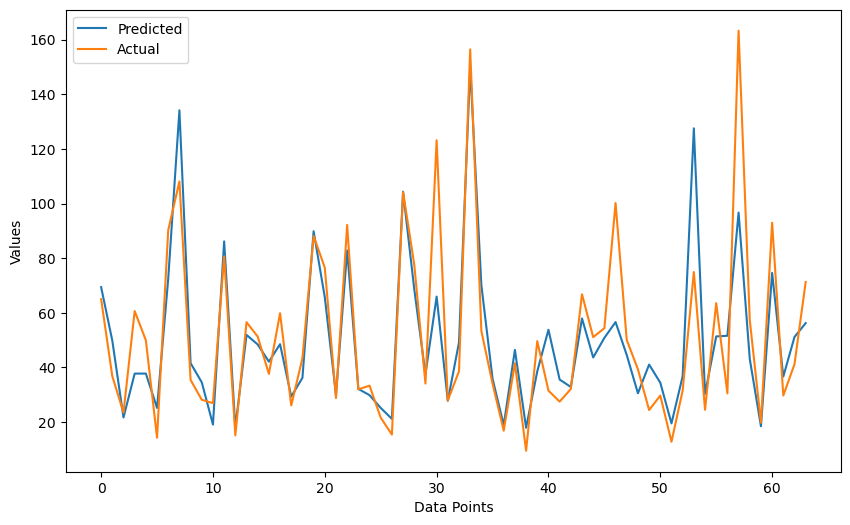

In [80]:
import matplotlib.pyplot as plt

predicted_values = []
actual_values = []

data, target = next(iter(val_loader))
x = [i for i in range(len(data))]
for i in range(len(data)):
    # Assuming 'device' is defined as follows:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    actual, predicted = try_single_prediction(val_loader, model, device, i)
    predicted_values.append(predicted)
    actual_values.append(actual)

print(predicted_values)
print(actual_values)
print(x)

# Make sure x has the same length as predicted_values and actual_values
x = range(len(predicted_values))

plt.figure(figsize=(10, 6))
plt.plot(x, predicted_values, label='Predicted')
plt.plot(x, actual_values, label='Actual')
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.legend()
plt.show()


Graphical analysis of model performance

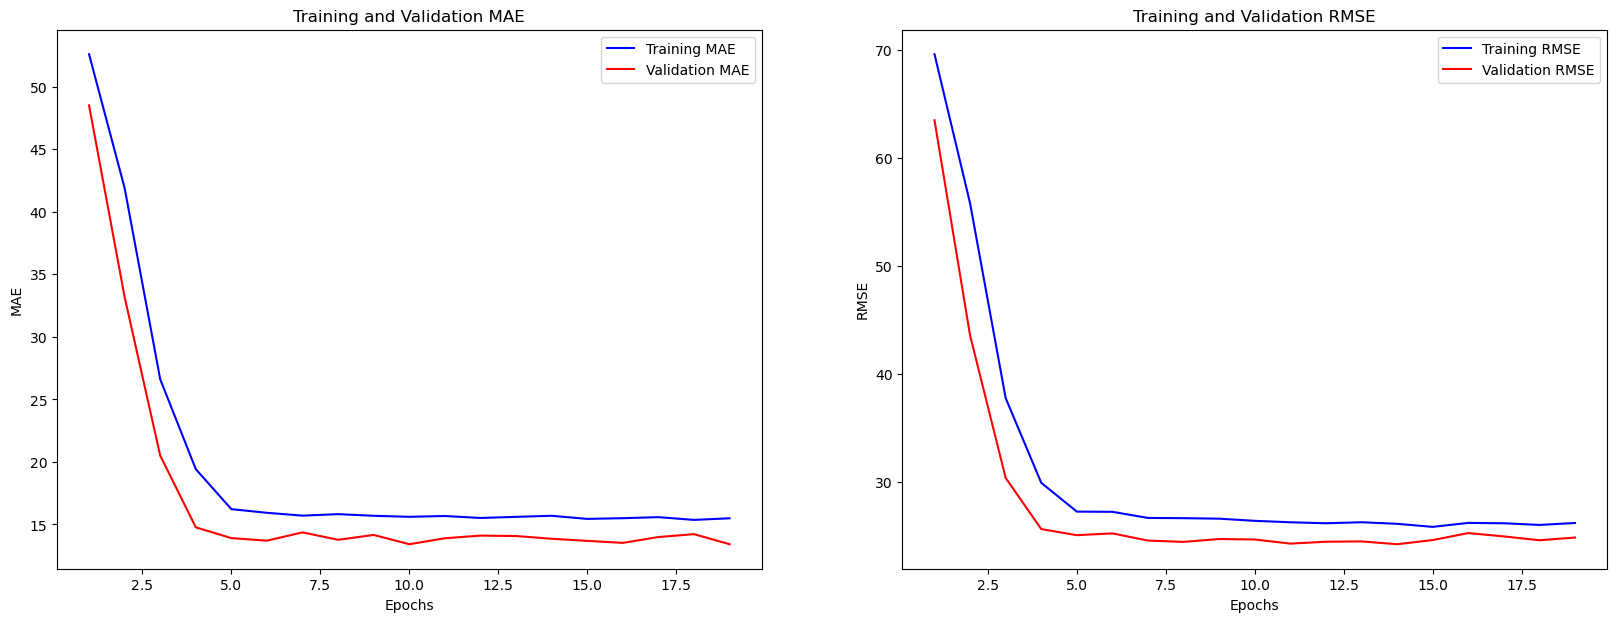

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Adjust epochs range for plotting based on actual epochs run
epochs_adjusted = range(1, epoch + 2)  

# Learning curve plotting for MAE and RMSE
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# MAE Plot
ax[0].plot(epochs_adjusted, train_mae, 'b', label='Training MAE')
ax[0].plot(epochs_adjusted, val_mae, 'r', label='Validation MAE')
ax[0].set_title('Training and Validation MAE')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('MAE')
ax[0].legend()

# RMSE Plot
ax[1].plot(epochs_adjusted, train_rmse, 'b', label='Training RMSE')
ax[1].plot(epochs_adjusted, val_rmse, 'r', label='Validation RMSE')
ax[1].set_title('Training and Validation RMSE')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('RMSE')
ax[1].legend()

plt.show()
